## DSAE Markdown
This document is a runthrough of Peis autoencoder model.
Firstly we initialise our installed packages

In [1]:
import sys
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from keras.models import Model 
from keras.layers import Dense, Input, Dropout
from keras import regularizers
from functions import simulate_counts

ModuleNotFoundError: No module named 'tensorflow.python'

## Load and preprocess data
Having confirmed that the mutation types are regarded as the rows and the patients are regarede as the columns in this problem, anlysis will be carried out on a simulated pentanucleotide dataset.

In [4]:
nsigs = 5

latent_dim = nsigs

batch_size_n = 32

learning_rate = 0.001

#Pei makes a denoising, sparse autoencoder. This means that they add noise to the input data
noise_factor = 0.01 

#load data
mf_df, true_sigs, _ = simulate_counts(5, 3000)
penta = mf_df.index
mutation = [p[3:6] for p in penta]

#Pei standardises the input values by dividing by the max input value (maybe because all tutorials does this)
max_val = mf_df.max().max()

#Split data into test and train set
test_set_percent = 0.2

x_test = mf_df.sample(frac=test_set_percent)/max_val
x_train = mf_df.drop(x_test.index)/max_val

#Add normal noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = x_test.shape)

#clamp input data between 0 and 1. All entries are normalised such that mf.df = mf.df/max(mf.df)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


#column dimension in input data
original_dim = mf_df.shape[1]
print(original_dim)

print(mutation)

2780


# Define autoencoder
The following block creates a class to initialize a one-hidden-layer linear autoencoder, and a method for traning the one such model. 
The first part defines a single fully-connected neural layer as encoder and as decoder that works for training, but also defines seperate encoding and decoding models. This is for weight extraction. All training takes place in the 'autoencoder'. This seems heavily inspired from https://blog.keras.io/building-autoencoders-in-keras.html  

Calling keras.Model (or Model here) generates a NN where the forward pass is defined as the layers defined between the inputs and outputs

In [5]:

# -------------------------------------------- This defines the autoencoder --------------------------------------------
# Compress from original_dim => latent_dim 
encoding_dim = latent_dim

# this is our input placeholder
input_dim = Input(shape=(original_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation = "relu", activity_regularizer = regularizers.l1(1e-12))(input_dim)
#This is where you would stack layers

# "decoded" is the reconstruction of the input
decoded = Dense(original_dim, activation = "softmax")(encoded)
#This is where you would stack layers

# autoencoder model - This model maps an input to its reconstruction
autoencoder = Model(inputs = input_dim, outputs = decoded)


# -------------------------------------------- Seperate encoder model --------------------------------------------
# This model maps an input to its encoded representation
encoder = Model(inputs = input_dim, outputs = encoded)


# -------------------------------------------- Seperate decoder model --------------------------------------------
# create a placeholder for the hidden layer
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model( encoded_input, decoder_layer(encoded_input))



# -------------------------------------------- Compiler autoencoder --------------------------------------------

autoencoder.compile(optimizer='adam', loss='mse')


In [6]:
# training
epochs_n = 500
hist = autoencoder.fit(x_train_noisy, 
                       x_train, 
                       epochs=epochs_n, 
                       batch_size=batch_size_n, 
                       shuffle=True, 
                       validation_data=(x_test_noisy, x_test), verbose = 0)

Epoch 1/500
77/77 [==============================] - 0s 3ms/step - loss: 1.6879e-06 - val_loss: 1.3420e-06
Epoch 2/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6879e-06 - val_loss: 1.3420e-06
Epoch 3/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6879e-06 - val_loss: 1.3420e-06
Epoch 4/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6879e-06 - val_loss: 1.3419e-06
Epoch 5/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6879e-06 - val_loss: 1.3419e-06
Epoch 6/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6879e-06 - val_loss: 1.3419e-06
Epoch 7/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6879e-06 - val_loss: 1.3419e-06
Epoch 8/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6879e-06 - val_loss: 1.3419e-06
Epoch 9/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6879e-06 - val_loss: 1.3419e-06
Epoch 10/500
77/77 [=================

Epoch 77/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6873e-06 - val_loss: 1.3414e-06
Epoch 78/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6873e-06 - val_loss: 1.3414e-06
Epoch 79/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6873e-06 - val_loss: 1.3414e-06
Epoch 80/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6873e-06 - val_loss: 1.3414e-06
Epoch 81/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6872e-06 - val_loss: 1.3414e-06
Epoch 82/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6872e-06 - val_loss: 1.3414e-06
Epoch 83/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6872e-06 - val_loss: 1.3414e-06
Epoch 84/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6872e-06 - val_loss: 1.3414e-06
Epoch 85/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6872e-06 - val_loss: 1.3414e-06
Epoch 86/500
77/77 [========

77/77 [==============================] - 0s 1ms/step - loss: 1.6865e-06 - val_loss: 1.3408e-06
Epoch 153/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6865e-06 - val_loss: 1.3408e-06
Epoch 154/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6864e-06 - val_loss: 1.3408e-06
Epoch 155/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6864e-06 - val_loss: 1.3408e-06
Epoch 156/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6864e-06 - val_loss: 1.3408e-06
Epoch 157/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6864e-06 - val_loss: 1.3408e-06
Epoch 158/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6864e-06 - val_loss: 1.3408e-06
Epoch 159/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6864e-06 - val_loss: 1.3407e-06
Epoch 160/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6864e-06 - val_loss: 1.3407e-06
Epoch 161/500
77/77 [============

77/77 [==============================] - 0s 1ms/step - loss: 1.6855e-06 - val_loss: 1.3401e-06
Epoch 228/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6855e-06 - val_loss: 1.3401e-06
Epoch 229/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6855e-06 - val_loss: 1.3400e-06
Epoch 230/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6854e-06 - val_loss: 1.3400e-06
Epoch 231/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6854e-06 - val_loss: 1.3400e-06
Epoch 232/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6854e-06 - val_loss: 1.3400e-06
Epoch 233/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6854e-06 - val_loss: 1.3400e-06
Epoch 234/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6854e-06 - val_loss: 1.3400e-06
Epoch 235/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6854e-06 - val_loss: 1.3400e-06
Epoch 236/500
77/77 [============

77/77 [==============================] - 0s 1ms/step - loss: 1.6843e-06 - val_loss: 1.3392e-06
Epoch 303/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6843e-06 - val_loss: 1.3392e-06
Epoch 304/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6842e-06 - val_loss: 1.3391e-06
Epoch 305/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6842e-06 - val_loss: 1.3391e-06
Epoch 306/500
77/77 [==============================] - 0s 2ms/step - loss: 1.6842e-06 - val_loss: 1.3391e-06
Epoch 307/500
77/77 [==============================] - 0s 2ms/step - loss: 1.6842e-06 - val_loss: 1.3391e-06
Epoch 308/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6842e-06 - val_loss: 1.3391e-06
Epoch 309/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6841e-06 - val_loss: 1.3391e-06
Epoch 310/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6841e-06 - val_loss: 1.3391e-06
Epoch 311/500
77/77 [============

77/77 [==============================] - 0s 2ms/step - loss: 1.6827e-06 - val_loss: 1.3381e-06
Epoch 378/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6827e-06 - val_loss: 1.3381e-06
Epoch 379/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6827e-06 - val_loss: 1.3380e-06
Epoch 380/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6826e-06 - val_loss: 1.3380e-06
Epoch 381/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6826e-06 - val_loss: 1.3380e-06
Epoch 382/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6826e-06 - val_loss: 1.3380e-06
Epoch 383/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6826e-06 - val_loss: 1.3380e-06
Epoch 384/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6825e-06 - val_loss: 1.3379e-06
Epoch 385/500
77/77 [==============================] - 0s 2ms/step - loss: 1.6825e-06 - val_loss: 1.3379e-06
Epoch 386/500
77/77 [============

77/77 [==============================] - 0s 1ms/step - loss: 1.6806e-06 - val_loss: 1.3366e-06
Epoch 453/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6805e-06 - val_loss: 1.3366e-06
Epoch 454/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6805e-06 - val_loss: 1.3366e-06
Epoch 455/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6805e-06 - val_loss: 1.3366e-06
Epoch 456/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6804e-06 - val_loss: 1.3365e-06
Epoch 457/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6804e-06 - val_loss: 1.3365e-06
Epoch 458/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6804e-06 - val_loss: 1.3365e-06
Epoch 459/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6803e-06 - val_loss: 1.3365e-06
Epoch 460/500
77/77 [==============================] - 0s 1ms/step - loss: 1.6803e-06 - val_loss: 1.3364e-06
Epoch 461/500
77/77 [============

## Calculate exposures
This chunk calculates encoding and decoding weights.  NB: these can be negative!!!! They do not specify what constitutes the exposures. Nowhere in the provided script are the signature matrix generated, but they do provide a tsv of generated signatures in the github we dont know where come from.

In [7]:
weights = []
for layer in encoder.layers: #seems redundant with only one layer
        weights.append(layer.get_weights())
        
weight_layer_df = pd.DataFrame(np.transpose(weights[1][0]), columns=mf_df.columns, index=range(1, latent_dim+1))
weight_layer_df.index.name = 'encodings'
#print encodings of the first 4 observations
print(weight_layer_df.iloc[:,0:4])

weights = []
for layer in decoder.layers:
        weights.append(layer.get_weights())
weight_layer_df = pd.DataFrame(weights[1][0], columns=mf_df.columns, index=range(1, latent_dim+1))
weight_layer_df.index.name = 'decodings'
#print decodings of the first 4 observations
print(weight_layer_df.iloc[:,0:4])

#Her prøver jeg at generere signaturerne ved at bruge den trænede encoder model på hele datasættet.
#Det får størrelsen 1536xnsigs fordi deres SBS input er pentanucleotiden for at få nok observationer til at træne.
sigs = pd.DataFrame(encoder.predict(mf_df))
print(sigs.shape) 

           Biliary-AdenoCA::SP117655  Biliary-AdenoCA::SP117556  \
encodings                                                         
1                          -0.033410                  -0.028750   
2                          -0.007186                   0.016034   
3                          -0.018382                  -0.012436   
4                          -0.013300                   0.007429   
5                          -0.045177                  -0.001184   

           Biliary-AdenoCA::SP117627  Biliary-AdenoCA::SP117775  
encodings                                                        
1                          -0.041790                  -0.015291  
2                          -0.042951                  -0.043452  
3                          -0.045344                   0.003034  
4                          -0.040786                   0.041602  
5                          -0.001454                  -0.013474  
           Biliary-AdenoCA::SP117655  Biliary-AdenoCA::SP117556  \
d

## Plot the results
Now we need to compress the 1536xnsigs siganture matrix into a 96xnsigs signature matrix, by summing up the the values in each trinucleotide

In [8]:

tri = [p[1] +"[" + m + "]" + p[3] for (m,p) in zip(mutation,penta)]
 
sigs['Mutation type'] = mutation
sigs['Trinucleotide'] = tri
sigs['Pentanucleotide'] = penta
sigs

sigs96 = pd.DataFrame(sigs.groupby('Trinucleotide').sum())
sigs96['Mutation'] = [s[2:5] for s in sigs96.index]
sigs96 = sigs96.sort_values('Mutation')
trinucleotide = sigs96.index
mutation = sigs96['Mutation']
sigs96 = sigs96.drop('Mutation', axis = 1)

sigs96

,0,1,2,3,4
Trinucleotide,,,,,
A[C>A]A,0.000000,0.000000,309.536194,760.494629,1087.757324
C[C>A]T,0.000000,3945.616455,0.000000,1781.150513,362.964600
C[C>A]G,0.000000,0.317177,19.151955,216.339691,268.940338
C[C>A]C,0.000000,21.764324,54.924515,1105.370361,743.149109
C[C>A]A,0.000000,71.188156,104.718262,905.826965,1285.406860
...,...,...,...,...,...
A[T>G]G,0.000000,183.085480,6.772204,1.185161,240.478256
A[T>G]C,0.065294,377.825531,44.820118,0.000000,309.168304
A[T>G]A,176.546997,395.901978,72.900475,1.434479,544.100220


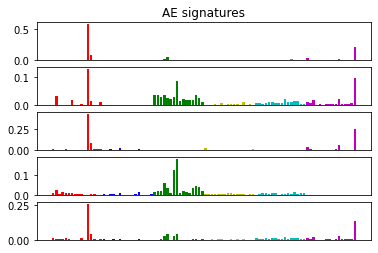

In [9]:
#plot the results
def plotsigs(context, mutation, signatures, nsigs, title):
    colors = {'C>A': 'r', 'C>G': 'b', 'C>T': 'g', 
                'T>A' : 'y', 'T>C': 'c','T>G' : 'm' }
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    for i in range(nsigs):
        plt.subplot(nsigs,1, (i+1))
        #plt.figure(figsize=(20,7))
        plt.bar(x = context, 
                height =  signatures[:,i]/np.sum(signatures[:,i]), 
                color = [colors[i] for i in mutation])
        plt.xticks([])
        if i == 0:
            plt.title(title)
    #plt.legend(handles,labels)
    #plt.xticks(rotation=90)
    plt.show()


plotsigs(trinucleotide, mutation, sigs96.to_numpy(), nsigs, "AE signatures") 

Det  her ser selvfølgelig lidt fjollet ud, men det er også fordi vi har forsøgt at beskrive hele PCAWG med 5 signaturer. Men det er sådan her metoden fungerer